In [2]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import glm
from statsmodels.api import families
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from dtreeviz.trees import dtreeviz


df = pd.read_csv('../data/curated/engineered-data.csv')
df.columns

Index(['suburb', 'postcode', 'price', 'propertyType', 'bedrooms', 'bathrooms',
       'parkingSpaces', 'studies', 'furnished', 'closest_primary_distance',
       'closest_secondary_distance', 'closest_train_distance',
       'closest_tram_distance', 'cbd_distance', 'cbd_duration',
       'zlogCrimerate', 'closest_bus_distance', 'closest_park_distance',
       'min_pri_icsea', 'min_sec_icsea', 'log_closest_park_distance',
       'log_closest_tram_distance', 'log_closest_train_distance',
       'park_walkability', 'is_primary_school_walkable',
       'is_secondary_school_walkable', 'is_tram_stop_walkable',
       'is_train_station_walkable', 'is_bus_walkable', 'city'],
      dtype='object')

In [3]:
df = df.dropna()

## Feature Selection by Mutual Information
Just external attributes considered here

In [4]:
mdl = SelectKBest(mutual_info_regression, k=5).fit(df[[
    'closest_primary_distance', 'closest_secondary_distance',
    'closest_train_distance', 'closest_tram_distance',
    'cbd_distance', 'zlogCrimerate',
    'closest_bus_distance', 'closest_park_distance',
    'min_sec_icsea']], df['price'])

best_features = mdl.get_feature_names_out([
    'closest_primary_distance', 'closest_secondary_distance',
    'closest_train_distance', 'closest_tram_distance',
    'cbd_distance', 'zlogCrimerate',
    'closest_bus_distance', 'closest_park_distance',
    'min_sec_icsea'])

print(list(best_features)[::-1])

['min_sec_icsea', 'closest_park_distance', 'zlogCrimerate', 'cbd_distance', 'closest_tram_distance']


## 0R


In [5]:
mae = sum(abs(df['price'].mean() - df['price'])) / len(df)

print(f'Mean abolute error of ${mae:.0f} for 0R on data.')


Mean abolute error of $148 for 0R on data.


## GLMs (log-link function)

In [6]:
model = glm(formula="""price ~ bedrooms + bathrooms + log_closest_tram_distance + log_closest_park_distance + log_closest_train_distance + zlogCrimerate """,
            families=families.Gaussian(link=families.links.log()),
            data=df)

model.fit().summary()

# Model interpretation:
#
# Effect of suburb properties on rental income
#
# Train station distance has no effect
# Properties close to tram stops are valued more
# Properties further from bus stops are valued more
# Properties close to parks are valued more
# Primary school ICSEA increases value alot

/home/lachstr/.local/lib/python3.10/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['families']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  price   No. Observations:                 8158
Model:                            GLM   Df Residuals:                     8148
Model Family:                Gaussian   Df Model:                            9
Link Function:               identity   Scale:                          24081.
Method:                          IRLS   Log-Likelihood:                -52724.
Date:                Mon, 10 Oct 2022   Deviance:                   1.9621e+08
Time:                        15:14:51   Pearson chi2:                 1.96e+08
No. Iterations:                     3   Pseudo R-squ. (CS):             0.6095
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   1472.4062     27.583     53.381      0.000    1418.345    1526.468
bedrooms[T.2]                113.5010      5.296     21.431      0.000     103.121     123.881
bedrooms[T.3]                224.5894      6.085     36.909      0.000     212.663     236.516
bedrooms[T.4+]               315.2221      7.889     39.958      0.000     299.760     330.684
bathrooms[T.2]               117.9080      4.131     28.543      0.000     109.812     126.004
bathrooms[T.3+]              312.5060      9.437     33.115      0.000     294.010     331.002
log_closest_tram_distance    -31.6292      1.134    -27.889      0.000     -33.852     -29.406
log_closest_park_distance    -72.6818      2.780    -26.140      0.000     -78.131     -67.232
log_closest_train_distance   -38.6132      2.127    -18.154      0.000     -42.782     -34.444
zlogCrimerate                -35.3584      3.940     -8.974      0.000     -43.081     -27.636
==============================================================================================
"""

In [7]:
phat = model.fit().predict(df)
mae = sum(abs(phat - df['price'])) / len(df)
mae

print(f'Mean abolute error of ${mae:.0f} for the GLM on data.')

Mean abolute error of $101 for the GLM on data.


## Regression Tree

Mean abolute error of $104 for the Regression Tree on test data.


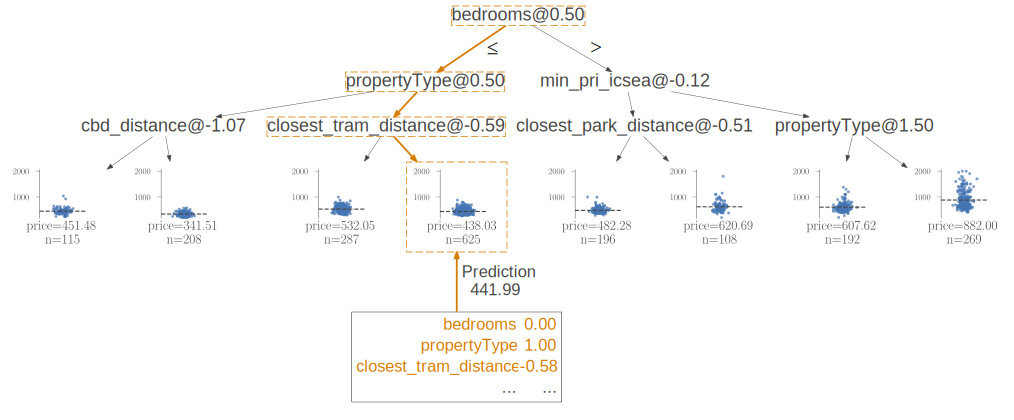

In [8]:
binary_features = ['is_secondary_school_walkable',
                   'is_primary_school_walkable',
                   'city', 'furnished']

ordinal_features = ['propertyType', 'bedrooms', 'bathrooms',
                    'parkingSpaces', 'studies']

continuous_features = ['closest_primary_distance',
                       'closest_secondary_distance', 'closest_train_distance',
                       'closest_tram_distance', 'cbd_distance', 'cbd_duration',
                       'zlogCrimerate', 'closest_bus_distance', 'closest_park_distance',
                       'min_pri_icsea', 'min_sec_icsea', 'log_closest_park_distance',
                       'log_closest_tram_distance', 'log_closest_train_distance']

features = binary_features + ordinal_features + continuous_features
df.loc[:, ordinal_features] = df[ordinal_features].astype(str)
for feat in ['bedrooms', 'bathrooms', 'parkingSpaces', 'studies']:
    df.loc[:, feat] = df[feat].apply(lambda n: n + ' ' + feat)

df_test = df.sample(2000, random_state=7)
test_set = set(df_test.index)
df_train = df[~df.index.isin(test_set)]

X_train, X_test = df_train[features], df_test[features]
y_train, y_test = df_train['price'], df_test['price']


def encode(X):
    """
    Used to keep labelling and encoding logic together

    :param X: feature dataframe, with labels
    :returns: X - encoded feature matrix, columns - names of columns of X
    """

    X_bin1 = label_binarize(X['is_secondary_school_walkable'], classes=[r'$<$1.5km', r'$>$1.5km'])
    X_bin2 = label_binarize(X['is_primary_school_walkable'], classes=[r'$<$1.5km', r'$>$1.5km'])
    X_bin3 = label_binarize(X['city'], classes=[True, False])

    orders = [['Unit', 'Apartment', 'House', 'Townhouse'],
              ['1 bedrooms', '2 bedrooms', '3 bedrooms', '4+ bedrooms'],
              ['1 bathrooms', '2 bathrooms', '3+ bathrooms'],
              ['0 parkingSpaces', '1 parkingSpaces', '2 parkingSpaces', '3+ parkingSpaces'],
              ['0 studies', '1 studies']]

    orderEncoder = OrdinalEncoder(categories=orders)
    X_ord = orderEncoder.fit_transform(X[ordinal_features])

    continuousEncoder = StandardScaler()

    X_con = continuousEncoder.fit_transform(X[continuous_features])

    labels = binary_features + ordinal_features + list(continuousEncoder.feature_names_in_)

    X_encoded = np.hstack((X_bin1, X_bin2, X_bin3, X_ord, X_con))

    return X_encoded, labels


X_train, columns = encode(X_train)
X_test, columns = encode(X_test)

model = DecisionTreeRegressor(criterion='squared_error',
                              splitter='best',
                              min_samples_split=400,
                              min_weight_fraction_leaf=0.01,
                              max_depth=3).fit(X_train, y_train)

Rsquared = model.score(X_test, y_test)
Rsquared

yhat = model.predict(X_test)
mae = sum(abs(yhat - y_test)) / len(y_test)
print(f'Mean abolute error of ${mae:.0f} for the Regression Tree on test data.')

X_demo, y_demo = X_test[:2000], y_test[:2000]

tree = dtreeviz(model, X_demo, y_demo, columns, target_name='price', scale=1.5,
                fancy=False, orientation='TD', instance_orientation='TD',
                X=X_test[-4])

tree


In [19]:
yhat = model.predict(X_test)
residuals = list(abs(y_test - yhat))
residuals.sort()
print(f'50% of test data accurate within ${residuals[len(residuals)//2]:.0f}/week')

50% of test data accurate within $67/week


In [10]:
# tree edited manually to improve presentation
tree.save('../plots/regression_tree_export_ugly.svg')